In [131]:
# Imports
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [132]:
# Import data
df_wdi = pd.read_csv('WDI-Environment-No-Commas.csv', encoding='utf-8', sep=";")
df_esg = pd.read_csv('ESGData.csv')

In [133]:
# Fix esg data to follow format of country and year as unit

# Create an empty DataFrame with no columns
df_new_esg = pd.DataFrame()
df_new_esg['country'] = None 

# Start at negative one to offset +1 for first row where value hasn't been placed yet
country_index = -1

# Each row is a country and one indicator variable, listing values for each year 1960 to 2020
for i in range(len(df_esg)):
    country = df_esg.loc[i, 'Country Name']
    indicator_code = df_esg.loc[i, 'Indicator Code']

    # Check if country name exists in dataframe already
    if not (df_new_esg['country'] == country).any():
        country_index += 1

    # Iterate through years in the row
    for j in range(1960, 2021):
        year_value = df_esg.loc[i, str(j)]

        # Add country and year to dataframe
        df_new_esg.loc[(country_index*61)+(j-1960), 'country'] = country
        df_new_esg.loc[(country_index*61)+(j-1960), 'year'] = j

        # Add new indicator value to dataframe
        df_new_esg.loc[(country_index*61)+(j-1960), str(indicator_code)] = year_value

In [134]:
# Merge the data

# Merge on country and year with outer to keep all entities
# data will be untouched merge of the two DataFrames
data = pd.merge(df_wdi, df_new_esg, on=['country', 'year'], how='outer')

# Save the combined DataFrame to a new CSV file
data.to_csv('Data.csv', index=False)

In [135]:
# Merge duplicate rows

# Assume that columns ending in a pattern like '_x', '_y' are to be combined
pattern = re.compile(r'(.+)_[xy]$')

# Use a defaultdict to store lists of columns that share the base name
from collections import defaultdict
columns_to_combine = defaultdict(list)

# Identify columns that match the pattern
for column in data.columns:
    match = pattern.match(column)
    if match:
        # Store in groups based on the base column name
        base_name = match.group(1)
        columns_to_combine[base_name].append(column)

# Now loop through and combine columns as needed
for base_column, cols in columns_to_combine.items():
    # You can use any logic here for combining the columns, the following is just one example
    data[base_column] = data[cols].apply(lambda x: x.bfill().ffill().iloc[0], axis=1)
    
    # Drop the original duplicate columns
    data.drop(cols, axis=1, inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17080 entries, 0 to 17079
Data columns (total 89 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         16104 non-null  float64
 1   iso2c              16043 non-null  object 
 2   country            17080 non-null  object 
 3   year               17080 non-null  float64
 4   EN.ATM.PM25.MC.ZS  2880 non-null   float64
 5   NY.GDP.TOTL.RT.ZS  10816 non-null  float64
 6   ER.LND.PTLD.ZS     770 non-null    float64
 7   ER.MRN.PTMR.ZS     607 non-null    float64
 8   EG.ELC.ACCS.UR.ZS  6127 non-null   float64
 9   SH.H2O.BASW.UR.ZS  3942 non-null   float64
 10  SH.STA.BASS.UR.ZS  3908 non-null   float64
 11  EG.ELC.ACCS.RU.ZS  5959 non-null   float64
 12  SH.STA.BASS.RU.ZS  3783 non-null   float64
 13  SH.H2O.BASW.RU.ZS  3774 non-null   float64
 14  ER.H2O.INTR.PC     2540 non-null   float64
 15  iso3c              15860 non-null  object 
 16  region             158

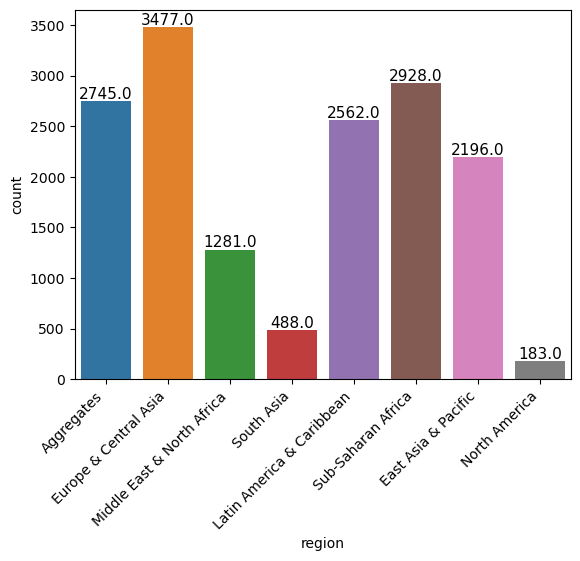

In [66]:
# Explore data: Seaborn/Plotly (eg. histograms)

# Count the number of data points for each region
ax = sns.countplot(x='region', data=data);

# Add count labels to each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

# Rotate x-axis labels
plt.xticks(rotation=45);

# Adjust x-axis labels position
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.show()

In [136]:
# Split data into different regions

# Class holding information specific for each region
class Region:
    def __init__(self, name, df):
        # df will be edited and cleaned to fit the needs of the model
        self.df = df
        self.name = name

# Create dictionary holding class for each region's data
regions = dict()

df_eu = data[data['region'] == 'Europe & Central Asia']
regions['df_eu'] = Region('Europe & Central Asia', df_eu)

df_me = data[data['region'] == 'Middle East & North Africa']
regions['df_me'] = Region('Middle East & North Africa', df_me)

df_sa = data[data['region'] == 'South Asia']
regions['df_sa'] = Region('South Asia', df_sa)

df_la = data[data['region'] == 'Latin America & Caribbean']
regions['df_la'] = Region('Latin America & Caribbean', df_la)

df_ssa = data[data['region'] == 'Sub-Saharan Africa']
regions['df_ssa'] = Region('Sub-Saharan Africa', df_ssa)

df_ea = data[data['region'] == 'East Asia & Pacific']
regions['df_ea'] = Region('East Asia & Pacific', df_ea)

df_na = data[data['region'] == 'North America']
regions['df_na'] = Region('North America', df_na)

In [137]:
# Define independent variables and target variables from data

# Specify which columns are independent variables (features) and which is the target variable
feature_columns = ['EG.ELC.ACCS.ZS', 'SH.H2O.BASW.UR.ZS', 'SH.STA.BASS.UR.ZS', 'EG.ELC.ACCS.UR.ZS',
                   'EG.ELC.ACCS.RU.ZS', 'SH.STA.BASS.RU.ZS', 'SH.H2O.BASW.RU.ZS', 'SH.MED.BEDS.ZS',
                   'SL.TLF.ACTI.ZS', 'SP.DYN.LE00.IN', 'SE.ADT.LITR.ZS', 'SH.DYN.MORT', 'SP.POP.65UP.TO.ZS',
                   'SI.POV.NAHC', 'SN.ITK.DEFC.ZS', 'GB.XPD.RSDV.GD.ZS', 'SE.PRM.ENRR', 'IP.JRN.ARTC.SC',
                   'SL.UEM.TOTL.ZS', 'IT.NET.USER.ZS']  # List of feature column names
target_columns = ['AG.LND.FRST.ZS', 'ER.LND.PTLD.ZS', 'ER.MRN.PTMR.ZS', 'EG.FEC.RNEW.ZS', 'EG.ELC.RNEW.ZS',
                 'EG.USE.COMM.FO.ZS', 'EN.ATM.METH.PC', 'EN.ATM.NOXE.PC', 'EG.EGY.PRIM.PP.KD', 'EG.CFT.ACCS.ZS',
                 'NY.ADJ.DRES.GN.ZS', 'NY.ADJ.DFOR.GN.ZS', 'EN.ATM.CO2E.PC', 'EN.ATM.PM25.MC.M3']  # Name of target column

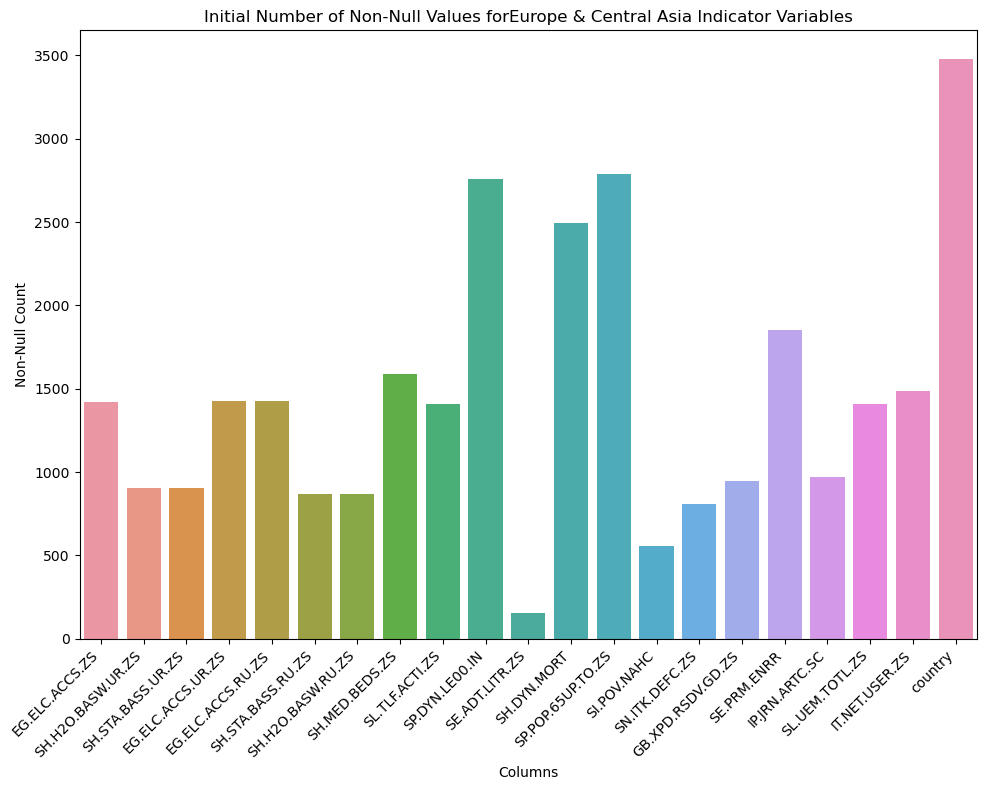

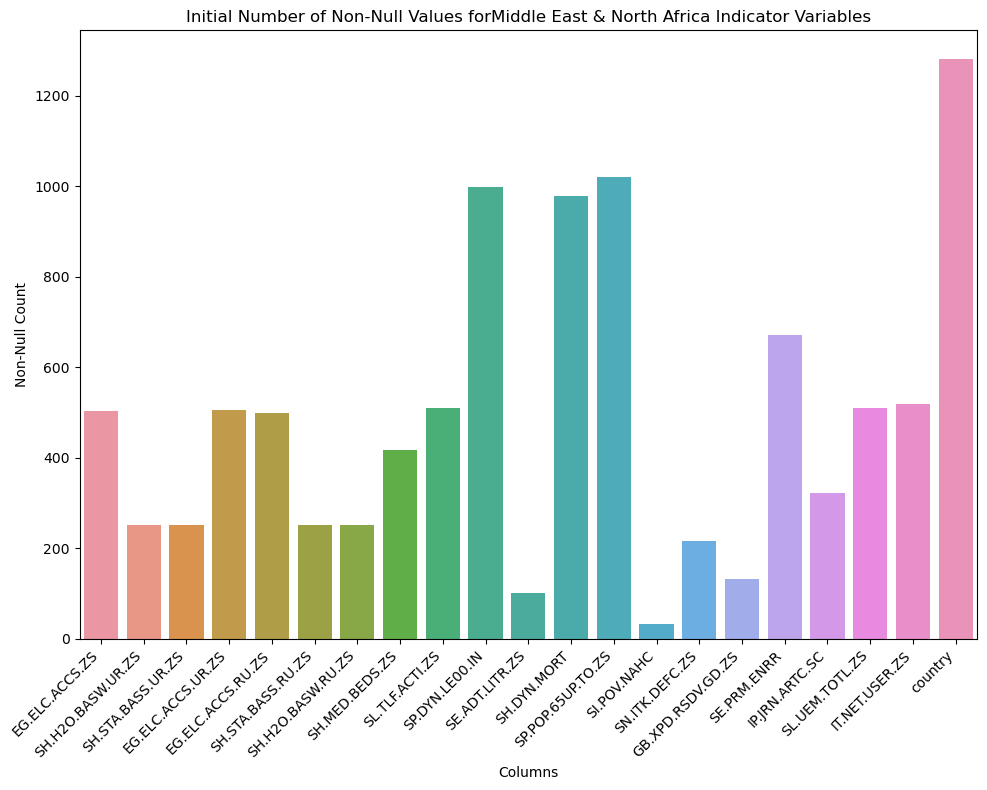

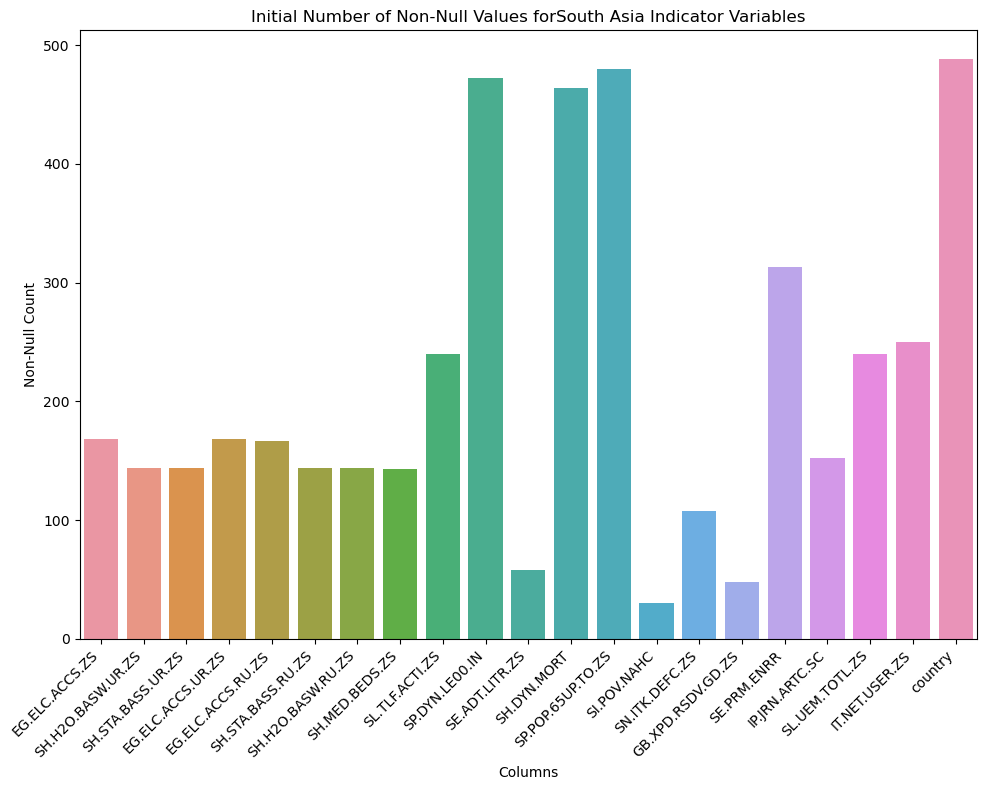

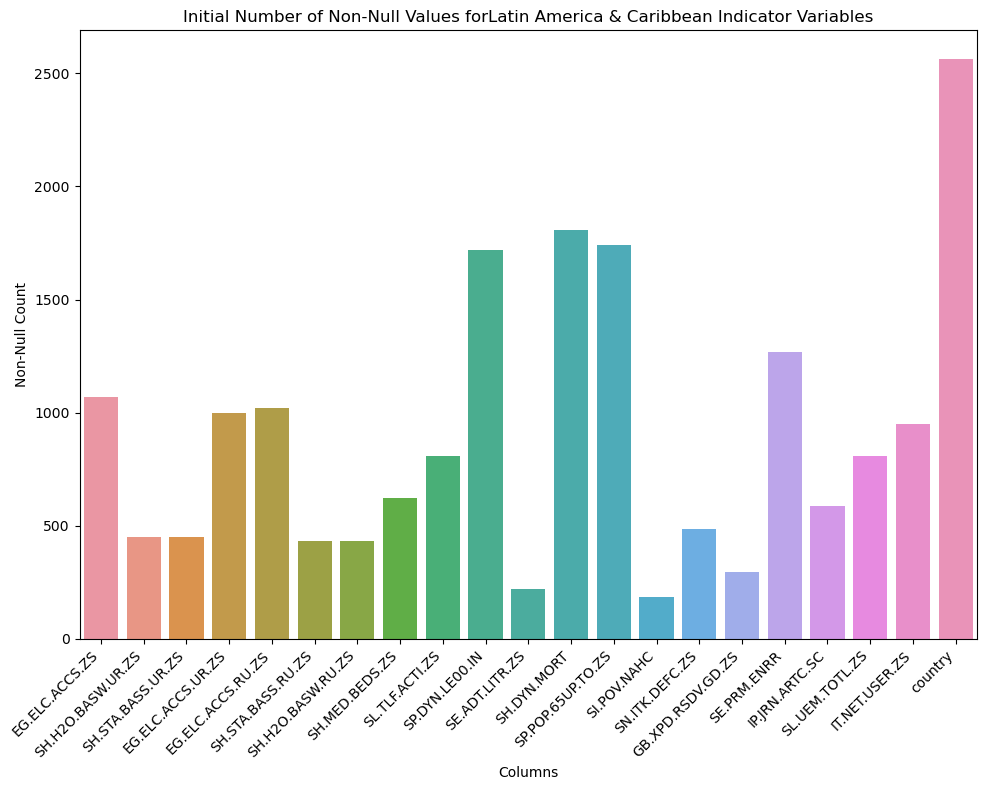

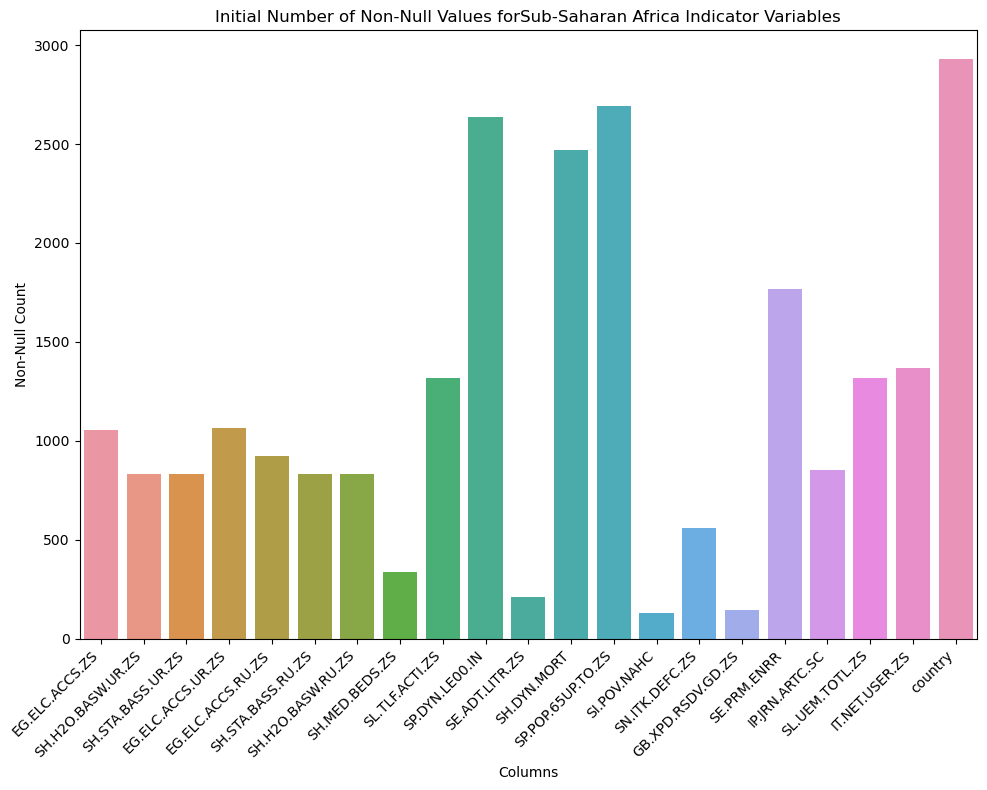

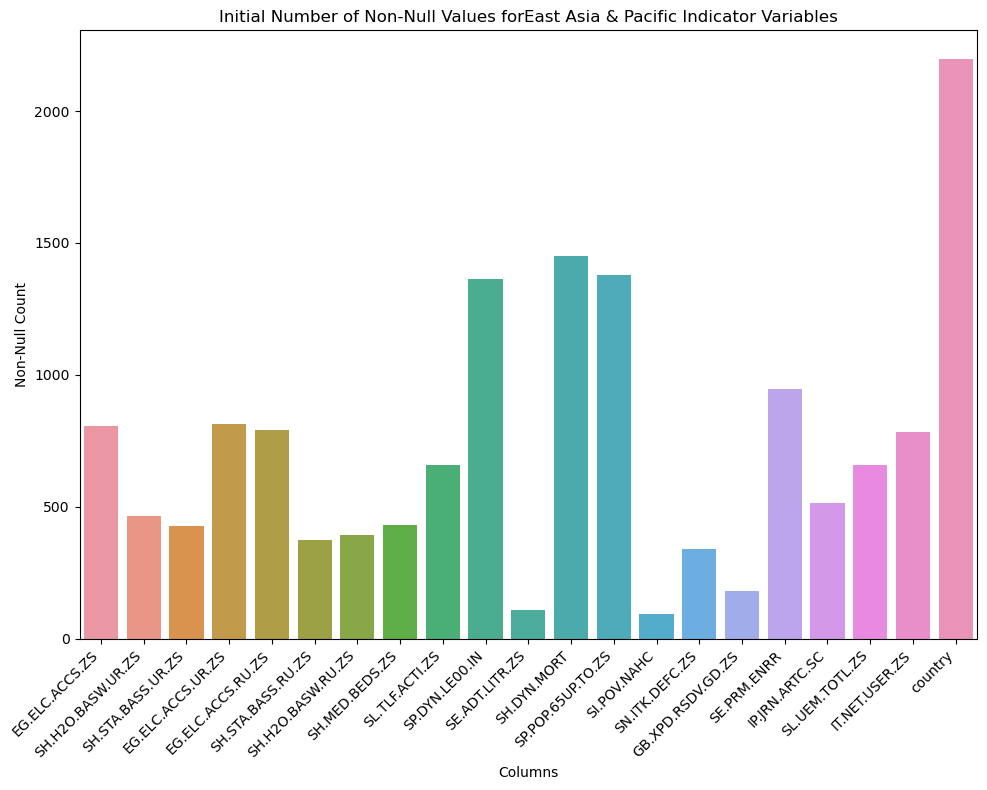

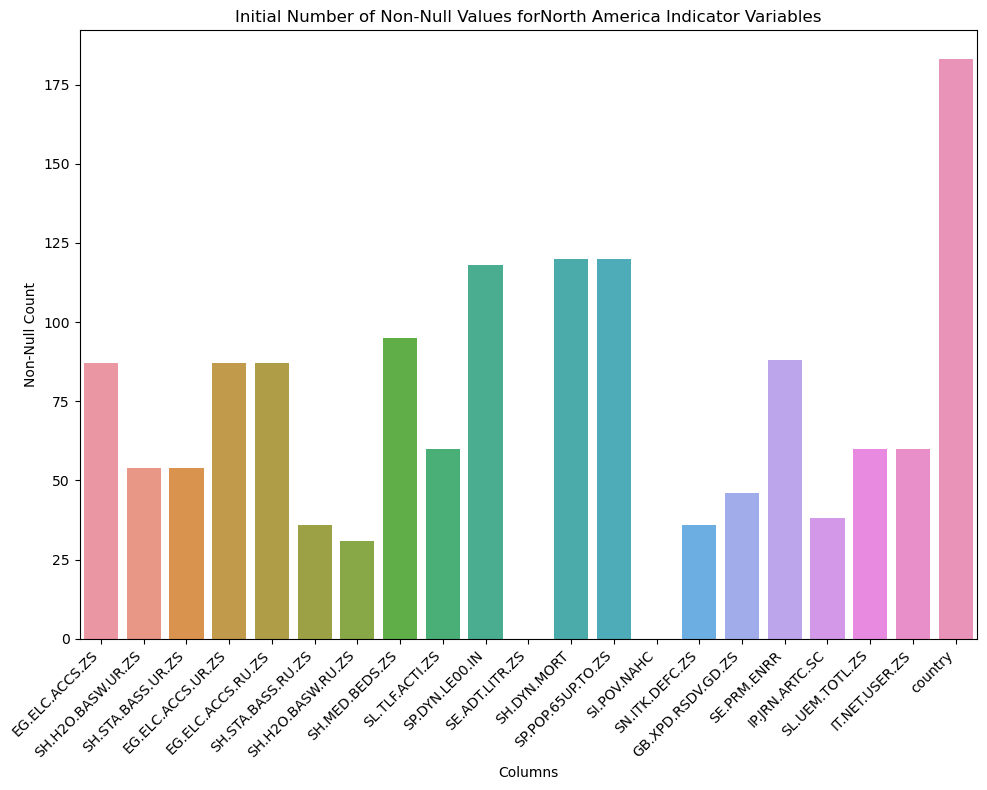

In [138]:
# Create graphs for each region seeing the number of values for each indicator column

for region in regions.values():
    graph_list = feature_columns
    graph_list.append('country')
    # Create a Series counting non-nulls for the indicator columns
    non_null_counts = region.df[graph_list].notnull().sum()
    
    # Convert the Series to DataFrame for Seaborn
    counts_df = non_null_counts.reset_index()
    counts_df.columns = ['Column', 'Non-Null Count']
    
    # Plotting
    plt.figure(figsize=(10, 8)) # Adjust the size as needed
    sns.barplot(x='Column', y='Non-Null Count', data=counts_df)
    
    plt.title('Initial Number of Non-Null Values for' + region.name + ' Indicator Variables')
    plt.xlabel('Columns')
    plt.ylabel('Non-Null Count')
    plt.xticks(rotation=45, ha="right") # Rotate the x-axis labels for better readability
    plt.tight_layout() # Adjust subplot params so the plot fits into the figure area
    
    # Show the plot
    plt.show()

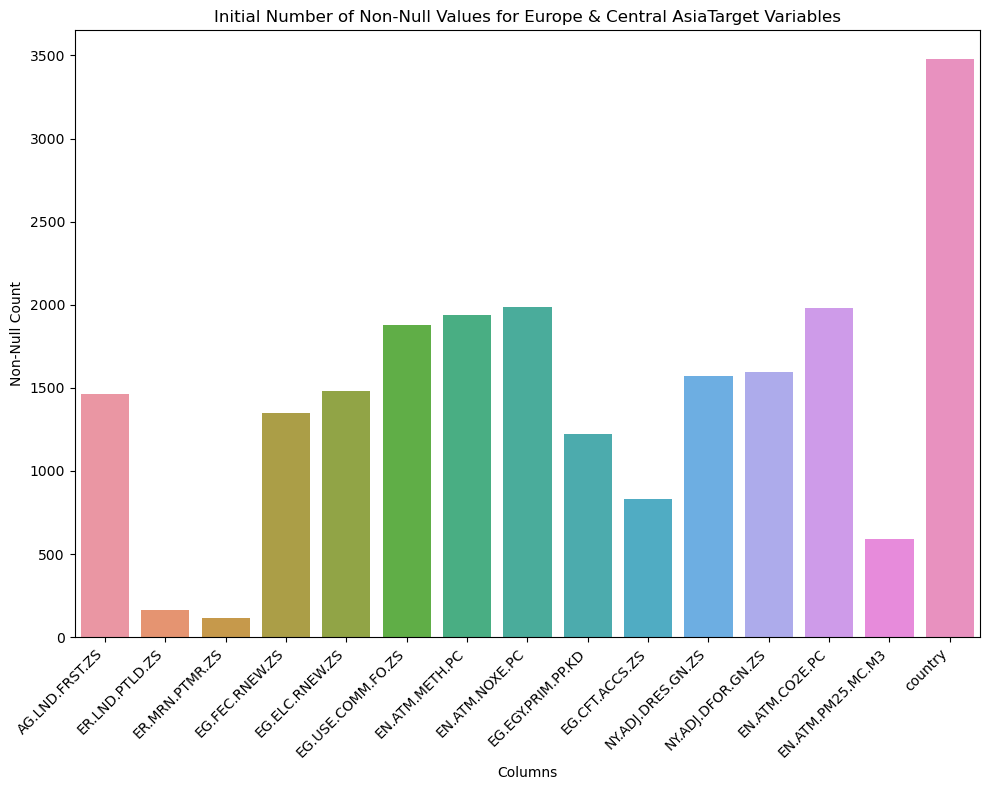

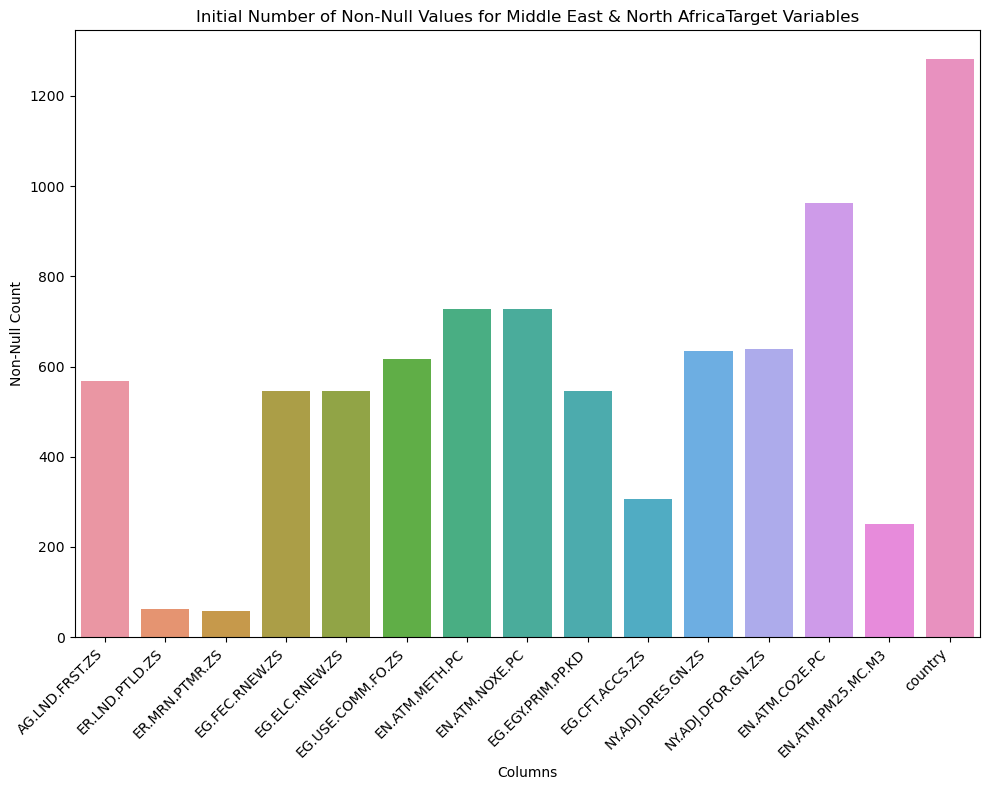

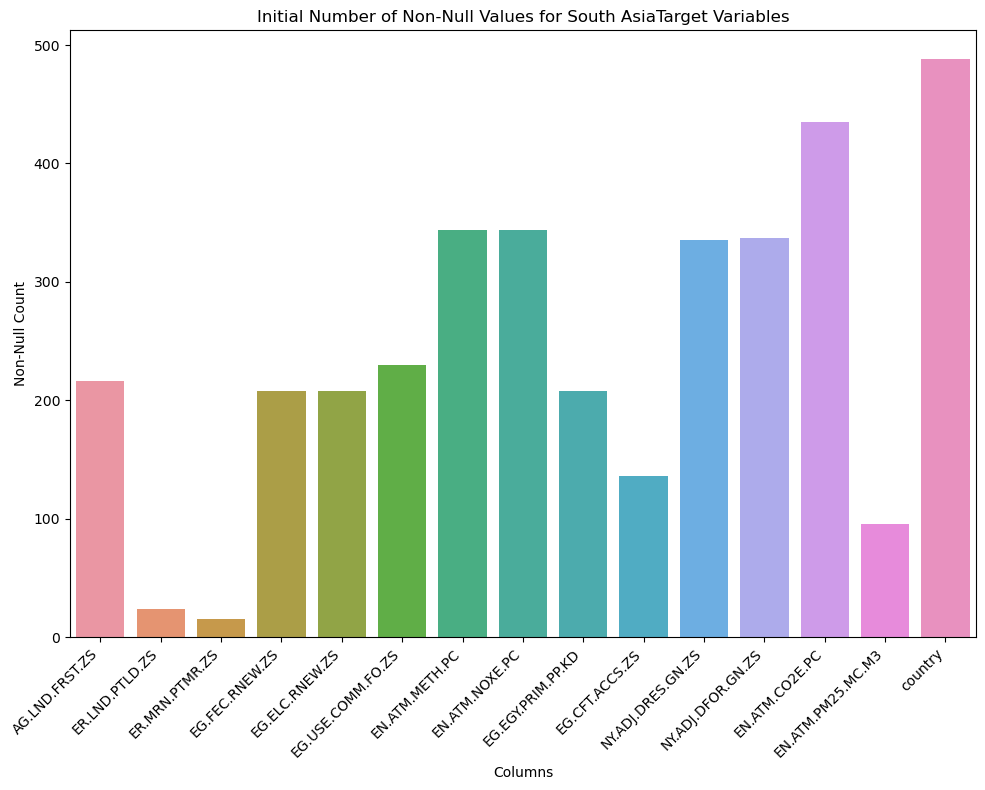

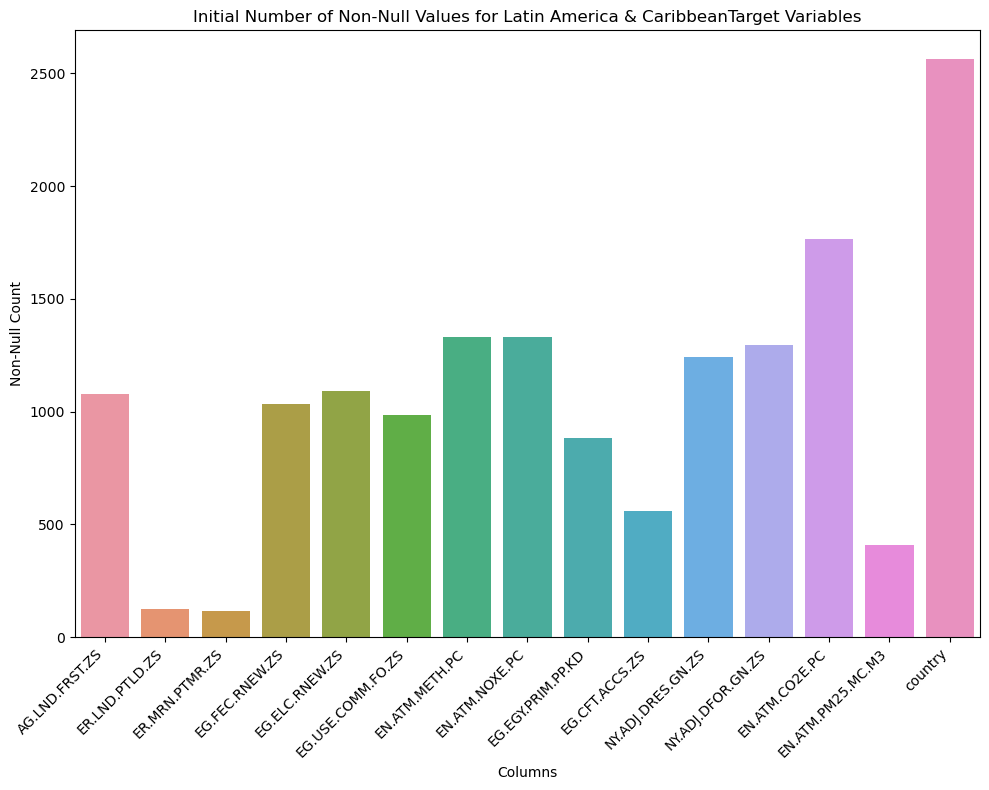

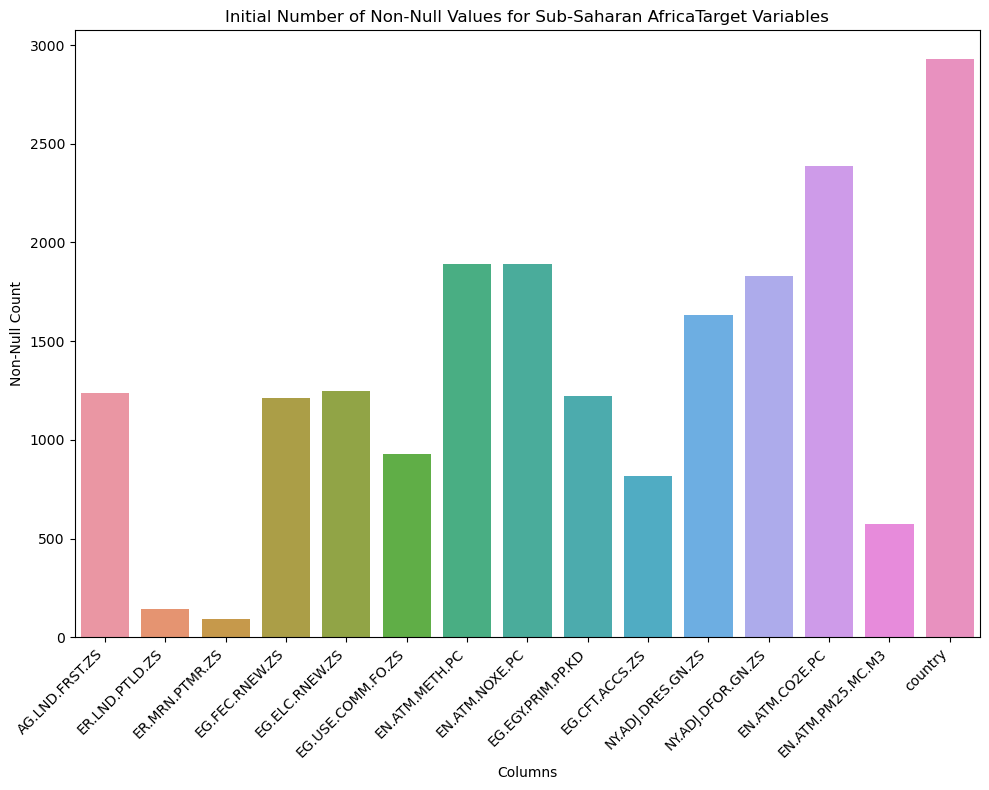

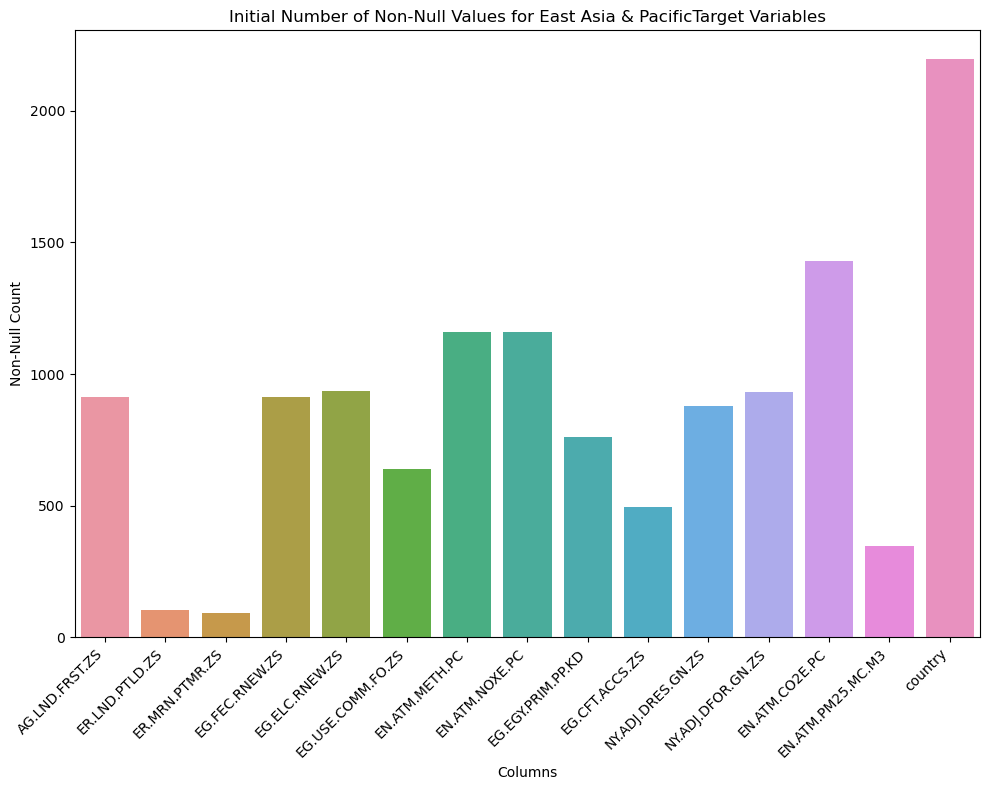

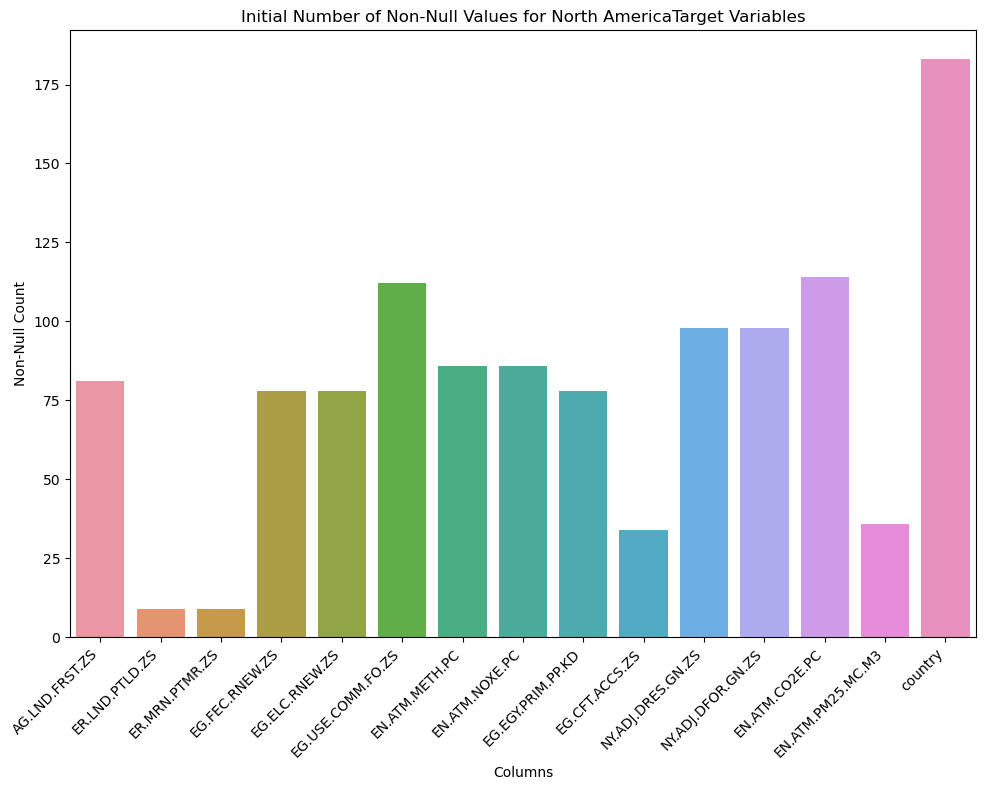

In [139]:
# Create graphs for each region seeing the number of values for each indicator column

for region in regions.values():
    graph_list = target_columns
    graph_list.append('country')
    
    # Create a Series counting non-nulls for the indicator columns
    non_null_counts = region.df[graph_list].notnull().sum()
    
    # Convert the Series to DataFrame for Seaborn
    counts_df = non_null_counts.reset_index()
    counts_df.columns = ['Column', 'Non-Null Count']
    
    # Plotting
    plt.figure(figsize=(10, 8)) # Adjust the size as needed
    sns.barplot(x='Column', y='Non-Null Count', data=counts_df)
    
    plt.title('Initial Number of Non-Null Values for ' + region.name + 'Target Variables')
    plt.xlabel('Columns')
    plt.ylabel('Non-Null Count')
    plt.xticks(rotation=45, ha="right") # Rotate the x-axis labels for better readability
    plt.tight_layout() # Adjust subplot params so the plot fits into the figure area
    
    # Show the plot
    plt.show()

In [148]:
# Changing target and indicator variables based on lack of data

# Get rid of initial variables that do not have enough data
feature_columns = ['EG.ELC.ACCS.ZS', 'SH.H2O.BASW.UR.ZS', 'SH.STA.BASS.UR.ZS', 'EG.ELC.ACCS.UR.ZS',
                   'EG.ELC.ACCS.RU.ZS', 'SH.STA.BASS.RU.ZS', 'SH.H2O.BASW.RU.ZS', 'SH.MED.BEDS.ZS',
                   'SL.TLF.ACTI.ZS', 'SP.DYN.LE00.IN', 'SH.DYN.MORT', 'SP.POP.65UP.TO.ZS', 'SN.ITK.DEFC.ZS',
                   'SE.PRM.ENRR', 'IP.JRN.ARTC.SC', 'SL.UEM.TOTL.ZS', 'IT.NET.USER.ZS']  # List of feature column names
target_columns = ['AG.LND.FRST.ZS', 'EG.FEC.RNEW.ZS', 'EG.ELC.RNEW.ZS', 'EG.USE.COMM.FO.ZS', 'EN.ATM.METH.PC', 'EN.ATM.NOXE.PC',
                  'EG.EGY.PRIM.PP.KD', 'EG.CFT.ACCS.ZS', 'NY.ADJ.DRES.GN.ZS', 'NY.ADJ.DFOR.GN.ZS', 'EN.ATM.CO2E.PC']  # Name of target column

In [149]:
# Get rid of rows with either all null indicator variables or all null target variables
for region in regions.values():
    # Drop rows that do not have at least one non-null values 
    # within the feature columns
    region.df = region.df.dropna(subset=feature_columns, thresh=1)
    region.df = region.df.dropna(subset=target_columns, thresh=1)

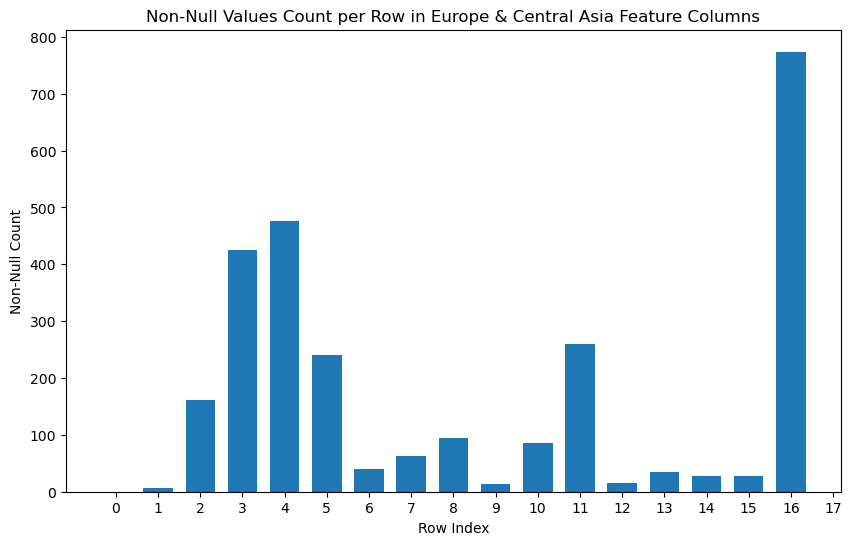

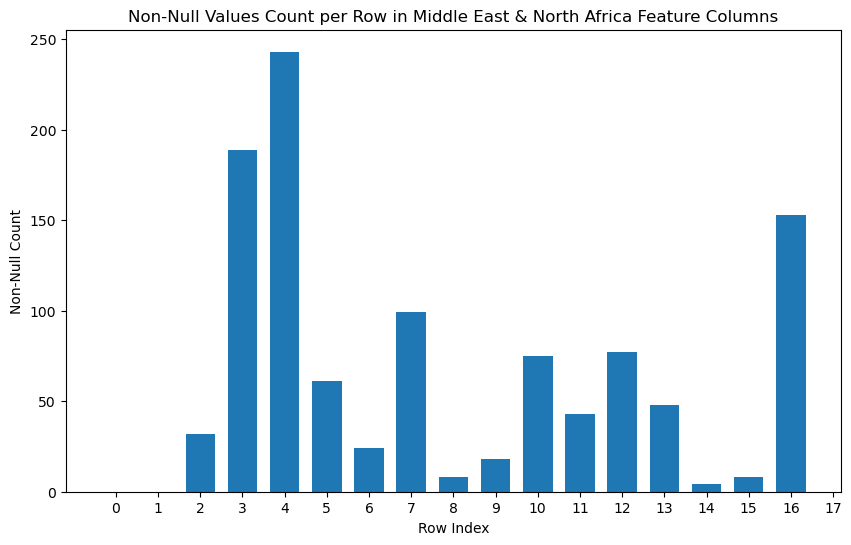

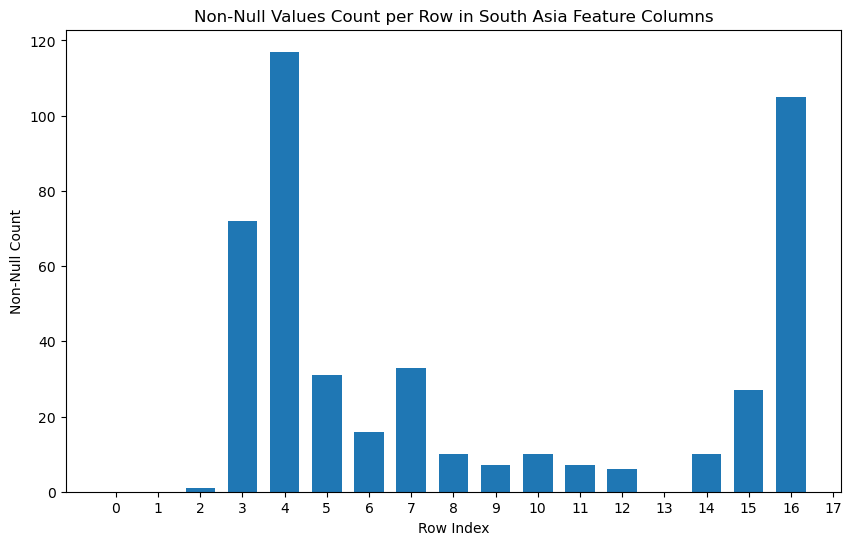

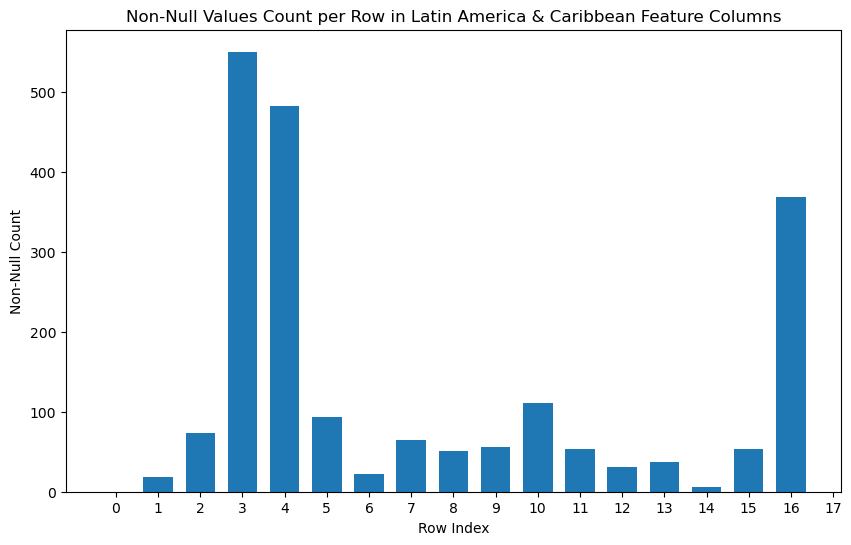

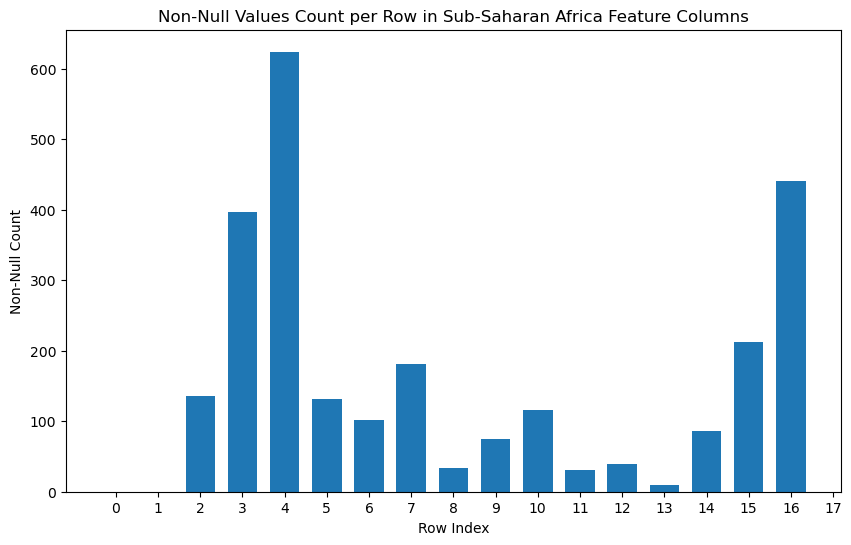

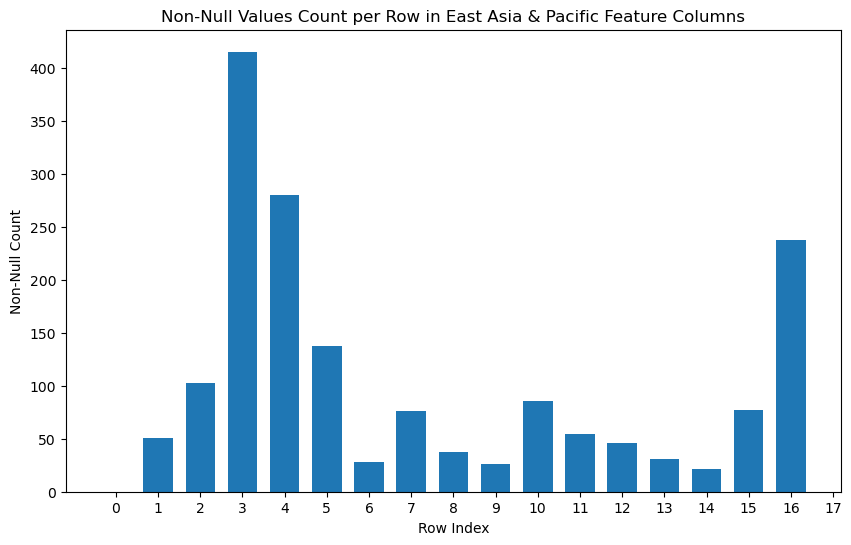

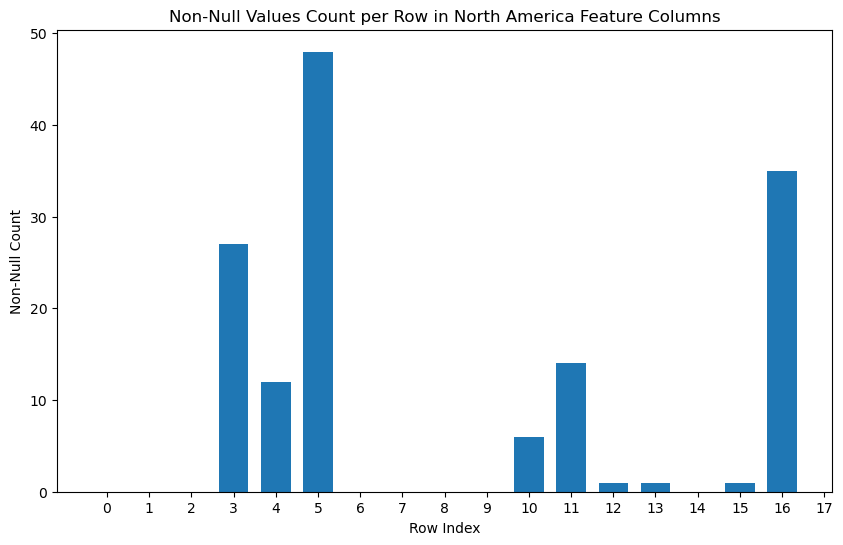

In [150]:
# Visualize number of non-null data for feature variables
for region in regions.values():
    # Calculate non-null counts for each row within the specified columns
    nonnull_counts_per_row = region.df[feature_columns].notnull().sum(axis=1)
    
    # Now create a histogram plot
    plt.figure(figsize=(10, 6))  # You may want to adjust the figure size based on your specific data
    plt.hist(nonnull_counts_per_row.values, bins=range(len(feature_columns) + 1), align='left', rwidth=0.7)
    
    # Improving the aesthetics and readability of the plot
    plt.title('Non-Null Values Count per Row in ' + region.name + ' Feature Columns')
    plt.xlabel('Row Index')
    plt.ylabel('Non-Null Count')
    plt.xticks(range(len(feature_columns) + 1))  # Set x-axis ticks to match the number of specified columns
    
    # Show the plot
    plt.show()

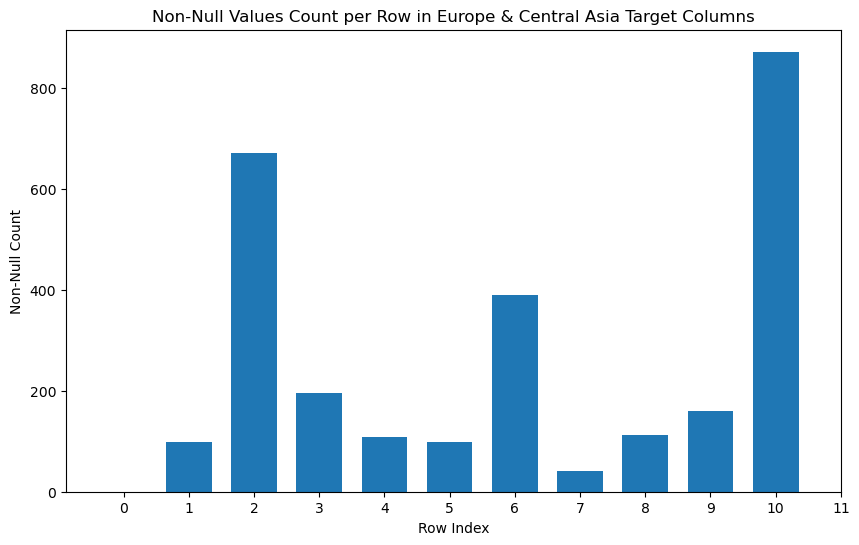

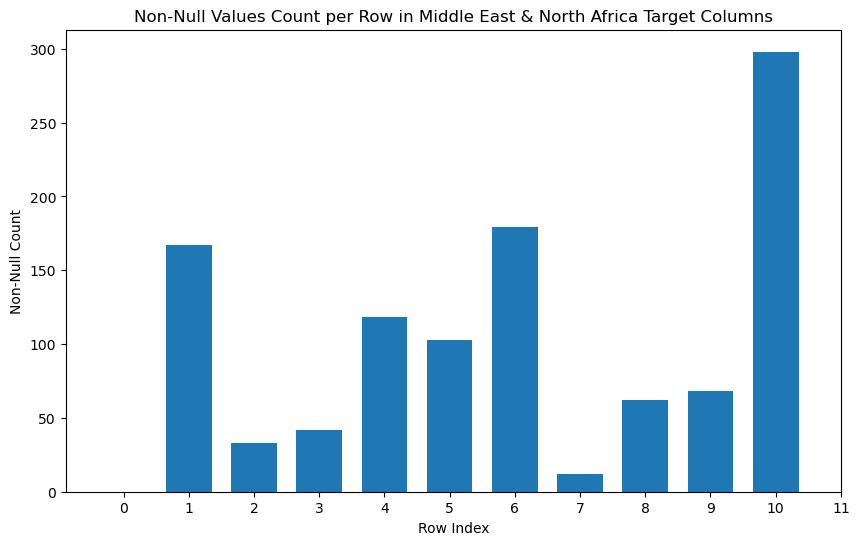

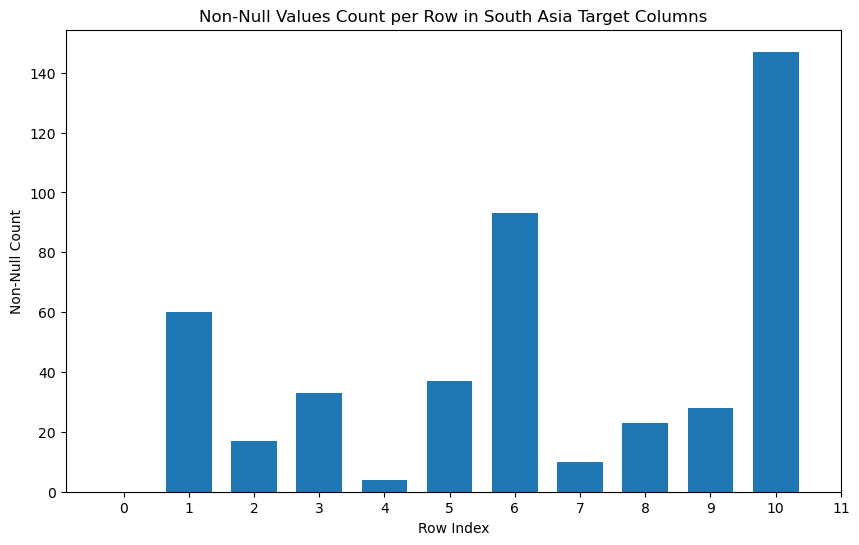

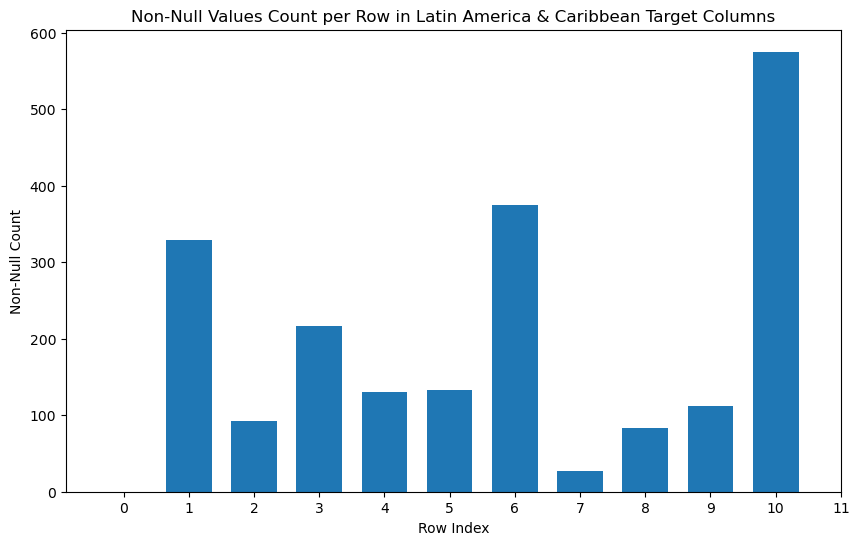

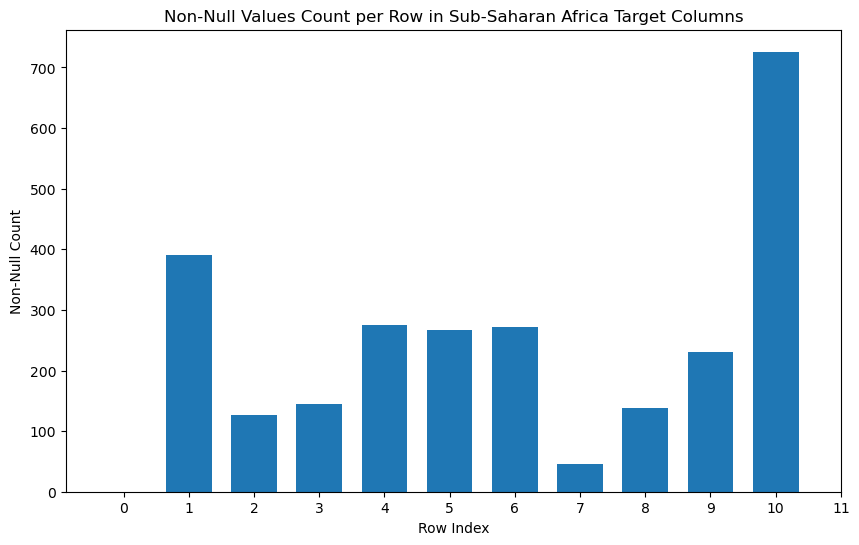

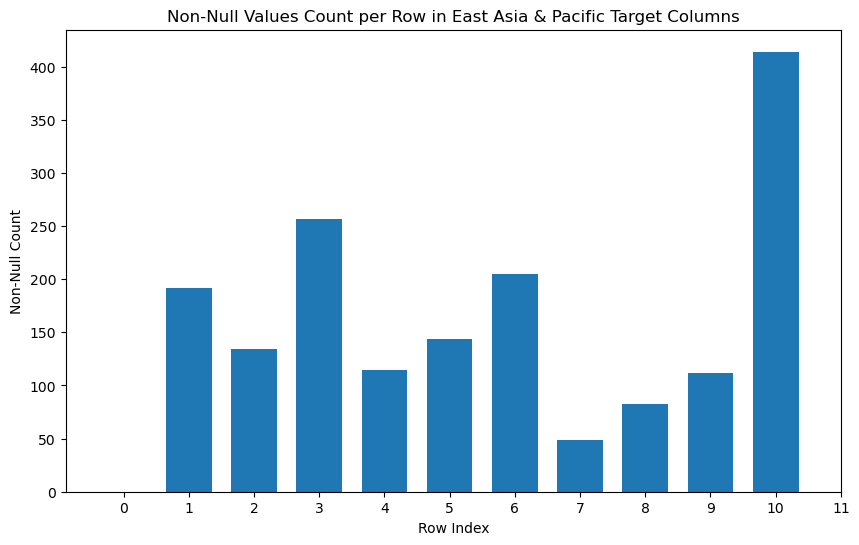

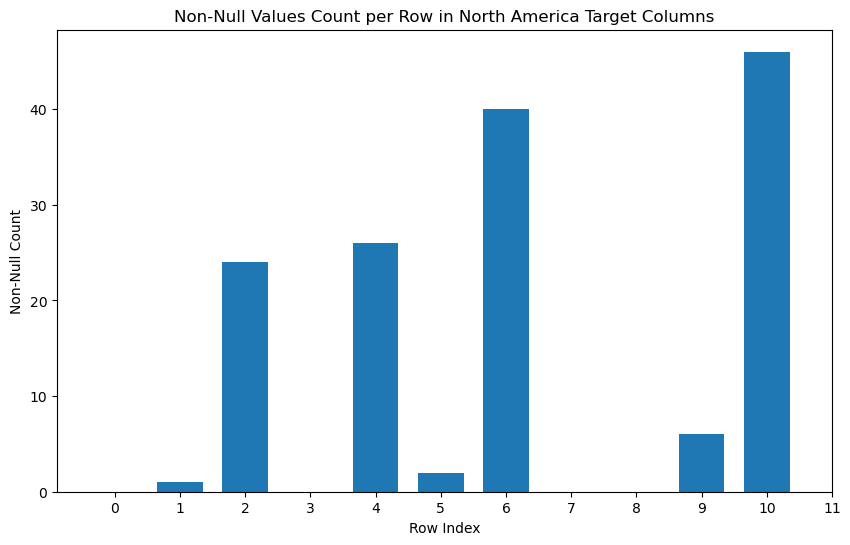

In [151]:
# Visualize number of non-null data for target variables
for region in regions.values():
    # Calculate non-null counts for each row within the specified columns
    nonnull_counts_per_row = region.df[target_columns].notnull().sum(axis=1)
    
    # Now create a line plot
    plt.figure(figsize=(10, 6))  # You may want to adjust the figure size based on your specific data
    plt.hist(nonnull_counts_per_row.values, bins=range(len(target_columns) + 1), align='left', rwidth=0.7)
    
    # Improving the aesthetics and readability of the plot
    plt.title('Non-Null Values Count per Row in ' + region.name + ' Target Columns')
    plt.xlabel('Row Index')
    plt.ylabel('Non-Null Count')
    plt.xticks(range(len(target_columns) + 1))  # Set x-axis ticks to match the number of specified columns
    
    # Show the plot
    plt.show()

In [152]:
# Clean the data by requiring a threshold of non-null values for row to be kept
# Get rid of 2 or below for indicator variables and 1 or less for target variables
for region in regions.values():
    # Drop rows that do not have at least one non-null values 
    # within the feature columns
    region.df = region.df.dropna(subset=feature_columns, thresh=3)
    region.df = region.df.dropna(subset=target_columns, thresh=2)
    region.df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2525 entries, 313 to 14877
Data columns (total 89 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         2525 non-null   float64
 1   iso2c              2525 non-null   object 
 2   country            2525 non-null   object 
 3   year               2525 non-null   float64
 4   EN.ATM.PM25.MC.ZS  584 non-null    float64
 5   NY.GDP.TOTL.RT.ZS  1897 non-null   float64
 6   ER.LND.PTLD.ZS     140 non-null    float64
 7   ER.MRN.PTMR.ZS     98 non-null     float64
 8   EG.ELC.ACCS.UR.ZS  1392 non-null   float64
 9   SH.H2O.BASW.UR.ZS  899 non-null    float64
 10  SH.STA.BASS.UR.ZS  897 non-null    float64
 11  EG.ELC.ACCS.RU.ZS  1392 non-null   float64
 12  SH.STA.BASS.RU.ZS  865 non-null    float64
 13  SH.H2O.BASW.RU.ZS  867 non-null    float64
 14  ER.H2O.INTR.PC     411 non-null    float64
 15  iso3c              2525 non-null   object 
 16  region             2525 no

In [121]:
# Split each region's data into train/dev/test

for region in regions.values():
    # Extract feature matrix (X) and target vector (y) from DataFrame
    region.X = region.df[feature_columns]  # Feature matrix (DataFrame with selected columns)
    region.y = region.df[target_columns]  # Target vector (Series with target column)

    # Split data into training set (80%) and combined dev/test set (20%)
    region.X_train, region.X_dev_test, region.y_train, region.y_dev_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Create model
# Rely on average (median/mean?) values found in big data to fill in holes? (NO)
# use average values to give a score to a value from 1-10
# Must analyze and decide if lower or higher is better for values